In [1]:
import sys
import os
import pickle
import glob
from joblib import Parallel, delayed

import scipy.stats as stats

from random import sample
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster,metrics
from nxontology.imports import from_file


In [2]:
with open("../data/processed/disease_ontograph.pkl", 'rb') as f:
    disease_ontograph = pickle.load(f)
    #Remove unconnected components
components = [i for i in nx.connected_components(disease_ontograph)]
disease_ontograph = disease_ontograph.subgraph(components[0]).copy()

diseases = [n for n in disease_ontograph.nodes if disease_ontograph.nodes[n].get('label') ==  'disease']

In [4]:
gard_gene_raw = pd.read_csv('../data/raw/disease_genes_palantir.csv')
non_root_gene_raw = pd.read_csv('../data/raw/non_root_disease_genes_palantir.csv')
gard_phen_raw =  pd.read_csv('../data/raw/disease_phenotypes_palantir.csv')

In [5]:
gard_diseases = pd.concat([gard_gene_raw[['OrphaCode','curie','label']],
                           non_root_gene_raw[['OrphaCode','curie','label']],
                           gard_phen_raw[['OrphaCode','curie','label']]],axis=0).drop_duplicates().reset_index()

In [7]:
N = 250
L = 250
D = 32 
K_dim = 20
m_file = "../data/clusters/kmeans/ontograph_embed_N{0}_L{1}_D{2}_K{3}_KMEANS_KOPT37.pkl".format(N,L,D,K_dim)

In [8]:
with open(m_file, 'rb') as f:
    cluster_model = pickle.load(f)
    
cluster_map = {dis:cluster_model.labels_[i] for i,dis in enumerate(diseases)}

In [14]:
cluster_sets = {i:[] for i in set(cluster_model.labels_)}

for i in cluster_map:
    cluster_sets[cluster_map[i]].append(i)

cluster_tuples = {i:[] for i in set(cluster_model.labels_)}

for cluster in cluster_sets:
    cluster_disease = cluster_sets[cluster]
    for i in range(len(cluster_disease)):
        for j in range(i+1,len(cluster_disease)):
            cluster_tuples[cluster].append((cluster_disease[i],cluster_disease[j]))

In [15]:
tuple_list = []
for i in range(len(gard2orpha)):
    for j in range(i+1,len(gard2orpha)):
        tuple_list.append((gard_diseases['curie'][i],gard_diseases['curie'][j]))

In [19]:
def semantic_sim(ontology,entities,ont_map,metric='intrinsic_ic_sanchez'):
    # TODO:
    # Check if entities are in map
    # Check if mapped entities are in ontology
    # Check if metric is valid
    # Try and catch
    sim = ontology.similarity(ont_map[entities[0]],ont_map[entities[1]], ic_metric=metric).lin

    return {entities:sim}

In [10]:
ordo = from_file('../data/raw/ordo_orphanet.owl')
gard2orpha = {i:'http://www.orpha.net/ORDO/Orphanet_{0}'.format(j) for i,j in zip(gard_diseases['curie'],gard_diseases['OrphaCode'])}

/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/nxontology/imports.py:67: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (72% confidence)
  onto = Prontology(handle=handle)
/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:286: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}creator' at 0x7f90d6002bd0> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:286: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}creator' at 0x7f90d6002c20> contains text but no `xsd:datatype`
  meta.annotations.add(self._extract_literal_pv(child))
/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:286: SyntaxWarning: <Element '{http://purl.org/dc/elements/1.1/}creator' at 0x7f90d6002c70> contains text but no `xsd:datatype`
  meta.annota

/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'http://www.orpha.net/ORDO/Orphanet_377788', using 'Disease'
  self._extract_term(class_, curies)
/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'http://www.orpha.net/ORDO/Orphanet_377789', using 'Malformation syndrome'
  self._extract_term(class_, curies)
/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'http://www.orpha.net/ORDO/Orphanet_377790', using 'Biological anomaly'
  self._extract_term(class_, curies)
/Users/sanjakjs/opt/anaconda3/envs/rdclust/lib/python3.8/site-packages/pronto/parsers/rdfxml.py:117: SyntaxWarning: several names found for 'http://www.orpha.net/ORDO/Orphanet_377791', using 'Morphological anomaly'
  self._extract_term(class_, curies)
/Users/sa

In [11]:
with open("../data/processed/ordo_semantic_similarity_within_cluster.pkl", 'rb') as f:
    within_cluster_sim = pickle.load(f)

In [16]:
within_cluster_dict = {}
for cluster_sim in within_cluster_sim:
    clust, clust_sim = list(cluster_sim.items())[0]
    within_cluster_dict[clust] = np.mean(list(clust_sim.values()))


In [17]:
within_means = list(within_cluster_dict.values())

In [20]:
mean_sim = []
for i in range(100):
    random_tuples = sample(tuple_list,100)
    random_sim = Parallel(n_jobs=8)(delayed(semantic_sim)(ordo,entities,gard2orpha,"intrinsic_ic_sanchez") for entities in random_tuples)
    random_sim_dict = {dis: sim for dis_sim in random_sim for dis, sim in dis_sim.items()}
    mean_sim.append(np.mean(list(random_sim_dict.values())))

In [26]:
similarity_df = pd.concat([pd.DataFrame({'Disease set type':'Random sample', 'Mean pairwise similarity':mean_sim}),
pd.DataFrame({'Disease set type':'Clustered', 'Mean pairwise similarity':within_means})])

In [27]:
stats.ttest_ind(mean_sim, within_means, alternative="two-sided")

Ttest_indResult(statistic=-7.63797819518472, pvalue=3.6316642592858883e-12)

In [28]:
1 - stats.t.cdf((np.mean(within_means) - np.mean(mean_sim))/np.std(mean_sim),99)

0.00023540543648958856

In [29]:
1 - stats.norm.cdf((np.mean(within_means) - np.mean(mean_sim))/np.std(mean_sim))

0.00014887975850763624

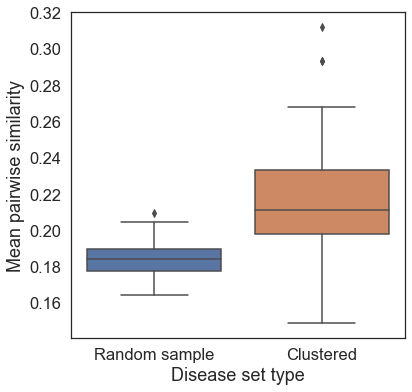

In [31]:
sns.set(font_scale = 1.5)
sns.set_style("white")
plt.figure(figsize=(6,6))
sns.boxplot(x='Disease set type', y='Mean pairwise similarity', data=similarity_df)
plt.show()